# Forecast using Single Layer DNN 

This notebook covers how to create a single layer dense neural net to forecast a time series

- Creation of a windowed dataset 
- Split features and labels 
- Create a model with 1 Dense Layer 
- Evaluate performance

In [26]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [27]:
# Let's install tensorflow 2.x first :)
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    '''
    Plot series of data

    Parameters
    ----------
    time : array of data
    series: array of data to plot in Y axis 
    format: format of basic line properties. Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
    start: from where to start plotting, optional. Default: 0
    end: up to where to plot data, optional. Default: None
    '''
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [30]:
def trend(time, slope=0):
    '''
    Produce a trend of data.
    Parameters
    ---------- 
    time: time series to plot 
    slope: slope to plot the series. optional, Default: 0
    '''
    return slope * time

In [31]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern by using np.where
    Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
    
    Parameters
    ----------
    season_time: to generate the condition of what to select from 
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [32]:
def seasonality(time, period, amplitude=1, phase=0):
    '''
    Repeats the same pattern at each period
    
    Parameters
    ----------
    time: to generate the season over x axis 
    period: how often will repeat
    amplitude: how many phases 
    phase: the position of the point in time
    '''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [33]:
def noise(time, noise_level=1, seed=None):
    '''
    Produce random noise into a time series 

    Parameters
    ----------
    time: series of values on X axis
    noise_level: to be produced, optional. Default: 1
    seed: seed to generate the noise, optional. Default: None 
    '''
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [34]:
# Define initial time series
time = np.arange(4 * 365 + 1, dtype="float32") 

In [35]:
# Define initial values for generation of different time series 
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [36]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

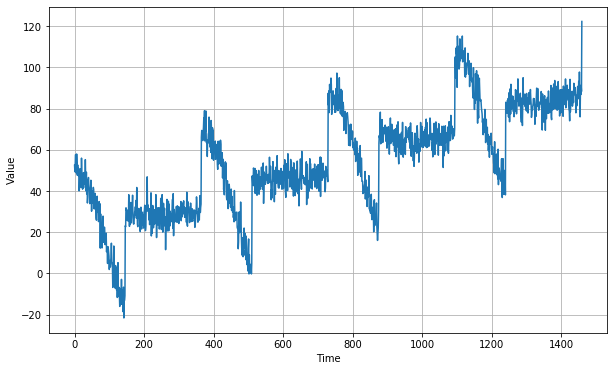

In [37]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [38]:
# Split into training and validation
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [39]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [40]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Creates a windowed dataset and returns only one from the batch 
    
    Parameters
    ----------
    series: time series data to set as dataset
    windows_size: size of the window to be created
    batch_size: size of the batch by window 
    shuffle_buffer: buffer size to take data and shuffle it around
    
    Returns a transformed dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [41]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [42]:
# Create a Dense layer with 1 output unit and assign it to variable
# this variable will serve to be accessed later 
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

In [43]:
# Create a model with Previous layer Created
model = tf.keras.models.Sequential([l0])

In [44]:
'''
Configure the model with: 
- Loss: mean squared error 
- Optimizer: Stochastic Gradient Descent 
'''
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [45]:
# Train the model for 100 epochs
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 31ms/step - loss: 288.1033
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 180.1196
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 157.7719
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 142.0765
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 131.0531
Epoch 6/100
31/31 [==============================] - 1s 24ms/step - loss: 125.1994
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 118.5811
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 112.9976
Epoch 9/100
31/31 [==============================] - 1s 17ms/step - loss: 109.2911
Epoch 10/100
31/31 [==============================] - 1s 18ms/step - loss: 101.2905
Epoch 11/100
31/31 [==============================] - 1s 18ms/step - loss: 101.5854
Epoch 12/100
31/31 [==============================] - 1s 18ms/step - loss: 98.3317
Ep

31/31 [==============================] - 1s 19ms/step - loss: 44.7854
Epoch 100/100
31/31 [==============================] - 1s 18ms/step - loss: 45.5778


In [46]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.08117335],
       [ 0.08145683],
       [-0.02704018],
       [-0.02197846],
       [ 0.05032526],
       [ 0.01943517],
       [ 0.04057488],
       [-0.05624466],
       [-0.10098002],
       [ 0.08874134],
       [ 0.04492733],
       [ 0.01129583],
       [-0.07286289],
       [-0.04751427],
       [ 0.10513392],
       [ 0.00352252],
       [ 0.09022354],
       [ 0.18890229],
       [ 0.2739812 ],
       [ 0.40336424]], dtype=float32), array([0.01700493], dtype=float32)]


In [47]:
# Create a moving average time series with the prediction created by the model
forecast = []
for time in range(len(series) - window_size):
    # Add the prediction to the forecast array 
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [48]:
forecast = forecast[split_time-window_size:]

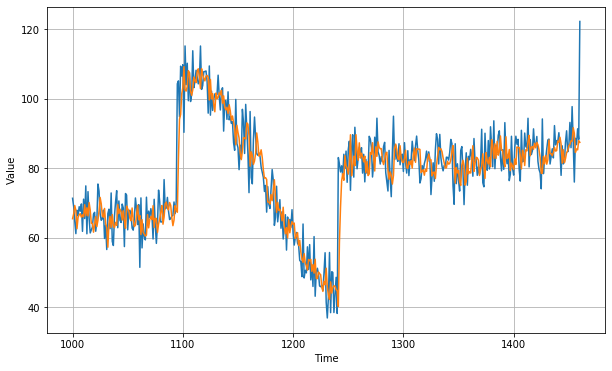

In [49]:
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [50]:
# Get the MAE metric
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0133443